In [1]:
import numpy as np
import torch
import advanced_cdm

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from torchvision import datasets, transforms
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)

In [6]:
enc_config, dec_config = advanced_cdm.config_ae_cifar()
encoder, decoder = advanced_cdm.setup_ae_model(enc_config, dec_config)
encoder = encoder.to(device)
decoder = decoder.to(device)

random_input = torch.randn(1, 3, 32, 32).to(device)
random_output = encoder(random_input)
print(random_output.shape)

torch.Size([1, 9, 16, 16])


In [10]:
from torch.utils.data import DataLoader
trainloader = DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2)
from torch.optim import Adam
optimizer = Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

for epoch in range(10):
    for i, data in enumerate(trainloader):
        optimizer.zero_grad()
        x, _ = data
        x_hat = encoder(x)
        x_hat = decoder(x_hat)
        loss = advanced_cdm.autoencoder_loss(x, x_hat)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print('epoch: {}, batch: {}, loss: {}'.format(epoch, i, loss.item()))

epoch: 0, batch: 0, loss: 0.0034825168550014496
epoch: 0, batch: 100, loss: 0.002918026177212596
epoch: 1, batch: 0, loss: 0.002991501474753022
epoch: 1, batch: 100, loss: 0.0024772968608886003
epoch: 2, batch: 0, loss: 0.002397044561803341
epoch: 2, batch: 100, loss: 0.0021901794243603945
epoch: 3, batch: 0, loss: 0.0020921509712934494
epoch: 3, batch: 100, loss: 0.002029772847890854
epoch: 4, batch: 0, loss: 0.001997305080294609
epoch: 4, batch: 100, loss: 0.001980530796572566
epoch: 5, batch: 0, loss: 0.0019719155970960855
epoch: 5, batch: 100, loss: 0.0018672920996323228
epoch: 6, batch: 0, loss: 0.0016370000084862113
epoch: 6, batch: 100, loss: 0.0017362491926178336
epoch: 7, batch: 0, loss: 0.0017564158188179135
epoch: 7, batch: 100, loss: 0.001721091102808714
epoch: 8, batch: 0, loss: 0.0015414752997457981
epoch: 8, batch: 100, loss: 0.0015166903613135219
epoch: 9, batch: 0, loss: 0.0016716662794351578
epoch: 9, batch: 100, loss: 0.0013992973836138844


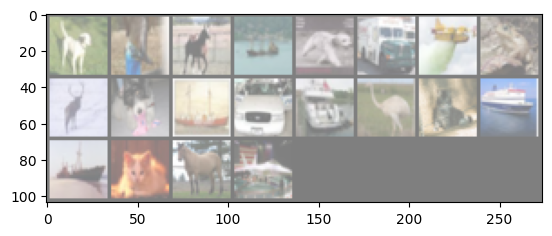

In [21]:
import matplotlib.pyplot as plt

# Plot the input and sample
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
# new trainloader with 20 images batch
img, _ = next(iter(DataLoader(trainset, batch_size=20, shuffle=True, num_workers=2)))
from torchvision import utils
imshow(utils.make_grid(img))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


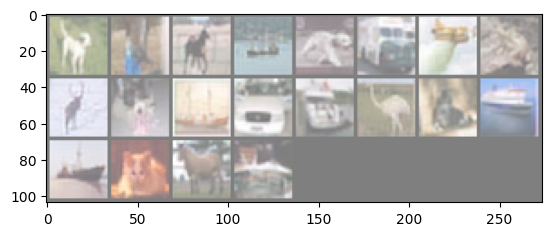

torch.Size([20, 9, 16, 16])


In [22]:
# show images
imshow(utils.make_grid(decoder(encoder(img))))
print(encoder(img).shape)

In [ ]:
import lossless.lossless_cdm as lossless
import torch.nn as nn
class AdvancedCDM(nn.Module):
    def __init__(self, vdm_config, unet_config, encoder, decoder):
        super(AdvancedCDM, self).__init__()
        self.encoder, self.decoder = encoder, decoder
        unet = advanced_cdm.UNetVDM(unet_config)
        self.vdm = lossless.VDM(vdm_config, unet, (9, 16, 16))

    def forward(self, x):
        x_hat = self.encoder(x)
        x_hat, _ = self.vdm(x_hat)
        return x_hat

    def reconstruct(self, x, steps=1000):
        x_hat = self.encoder(x)
        x_hat, _ = self.vdm.reconstruct(x_hat, steps)
        x_hat = self.decoder(x_hat)
        return x_hat

In [ ]:
# Training the model
vdm_config, unet_config = lossless.VDMConfig(), lossless.UnetConfig(input_channels=3, norm_groups=3)

trainloader = DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2)
model = AdvancedCDM(vdm_config, unet_config, encoder, decoder)

optimizer = Adam(model.parameters(), lr=1e-3)
for epoch in range(10):
    for i, data in enumerate(trainloader):
        optimizer.zero_grad()
        x, _ = data
        loss = model(x)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print('epoch: {}, batch: {}, loss: {}'.format(epoch, i, loss.item()))


In [ ]:
# show images
imshow(utils.make_grid(model.reconstruct(img)))